# Project Overview

This project builds a Convolutional Neural Network (CNN) to classify **German traffic signs using the GTSRB dataset**. The pipeline includes data preprocessing, model architecture design, training with augmentation, and evaluation on test data. The goal is to accurately recognize traffic signs for potential use in real-world autonomous driving applications.

#  Table of Contents
1. [Project Overview](#-project-overview)
2. [Import Libraries](#-1-import-libraries)
3. [Load Data](#-2-load-data)
4. [Data Preprocessing](#-3-data-preprocessing)
5. [Build Model](#-4-build-model)
6. [Compile Model](#-5-compile-model)
7. [Callbacks](#-6-callbacks)
8. [Train Model](#-7-train-model)
9. [Evaluate Model](#-8-evaluate-model)
10. [Save Model](#-9-save-model)
11. [Visualization](#-10-visualization)
12. [Conclusion](#-11-conclusion)

## Import libraries

We import **TensorFlow/Keras** for deep learning, **Matplotlib** for visualization, **Pandas/OS** for data handling, and **Scikit-learn** for splitting data.

In [56]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Load data

Define dataset paths for train, test, **and meta directories.** The GTSRB dataset provides labeled traffic sign images for training and testing.

In [57]:
# Set paths for the dataset
base_dir = "/kaggle/input/gtsrb-german-traffic-sign"
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')
meta_dir = os.path.join(base_dir, 'Meta')

## Data preprocessing


* Image resizing to (64×64).
* Normalization by rescaling pixel values.
* Data augmentation with rotation, shifting, zoom, and flipping to avoid overfitting.
* Split train/validation sets for balanced training.


In [58]:
# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 64, 64
BATCH_SIZE = 32

In [59]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [60]:
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [61]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2   # 20% for validation
)

# Training data
train_data = train_datagen.flow_from_directory(
    os.path.join(base_dir, "Train"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation data
val_data = train_datagen.flow_from_directory(
    os.path.join(base_dir, "Train"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_df = pd.read_csv(os.path.join(base_dir, "Test.csv"))

test_df["ClassId"] = test_df["ClassId"].astype(str)

test_df["Path"] = test_df["Path"].apply(lambda x: os.path.join(base_dir, x))

test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Path",
    y_col="ClassId",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


## Build model

We construct a CNN with 3 convolutional blocks:


* Convolution + Batch Normalization + MaxPooling + Dropout
* Dense layers with dropout for regularization
* Final Softmax layer for 43 traffic sign classe


In [62]:
def traffic_sign_model(img_height, img_width, num_classes=43):
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [63]:
model = traffic_sign_model(IMG_HEIGHT, IMG_WIDTH, num_classes=43)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,683,563 (36.94 MB)

 Trainable params: 9,680,235 (36.93 MB)

 Non-trainable params: 3,328 (13.00 KB)

## Compile the model

Use **Adam optimizer** with a small learning rate, **categorical crossentropy loss**, and track accuracy as the main metric.


In [64]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  
    loss='categorical_crossentropy',               
    metrics=['accuracy']                           
)

## Define callbacks



* EarlyStopping: Stops training when no improvement.
* ModelCheckpoint: Saves best model.
* ReduceLROnPlateau: Decreases learning rate if validation performance stalls.



In [65]:

callbacks = [
    EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
    ),  # stop if no improvement
    ModelCheckpoint(
        filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1
    ),  # save best model
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
    )  # reduce LR if stuck
]

## Train the model

Fit the CNN on augmented training data with validation tracking. We use 10 epochs (tunable).

In [66]:

history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=len(val_data),
    epochs=10,              # you can tune this
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2618 - loss: 3.2623
Epoch 1: val_loss improved from inf to 0.88412, saving model to best_model.h5
981/981 ━━━━━━━━━━━━━━━━━━━━ 65s 51ms/step - accuracy: 0.2620 - loss: 3.2612 - val_accuracy: 0.7475 - val_loss: 0.8841 - learning_rate: 1.0000e-04
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7795 - loss: 0.7595
Epoch 2: val_loss improved from 0.88412 to 0.37963, saving model to best_model.h5
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.7796 - loss: 0.7594 - val_accuracy: 0.8954 - val_loss: 0.3796 - learning_rate: 1.0000e-04
Epoch 3/10
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9170 - loss: 0.3042
Epoch 3: val_loss improved from 0.37963 to 0.23401, saving model to best_model.h5
981/981 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.9171 - loss: 0.3041 - val_accuracy: 0.9324 - val_loss: 0.2340 - learning_rate: 1.0000e-04
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - a

##  Evaluatation

Evaluate the trained CNN on **the test dataset**. Report **loss and accuracy**.

In [67]:
loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.9778 - loss: 0.0836
Test Loss: 0.0784912109375
Test Accuracy: 0.9782264232635498


In [68]:
# Save he model
model.save("traffic_sign_classification_model.h5")

In [69]:
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

## Visualisation

Plot accuracy and loss curves for both training and validation phases across epochs. This helps to analyze overfitting/underfitting.

Text(0.5, 1.0, 'Accuracy over Epochs')

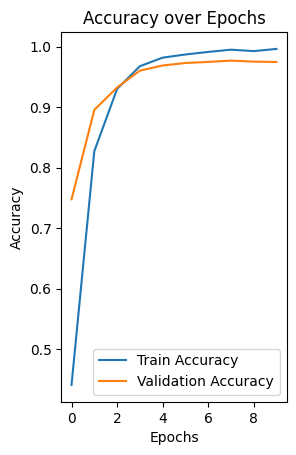

In [70]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

Text(0.5, 1.0, 'Loss over Epochs')

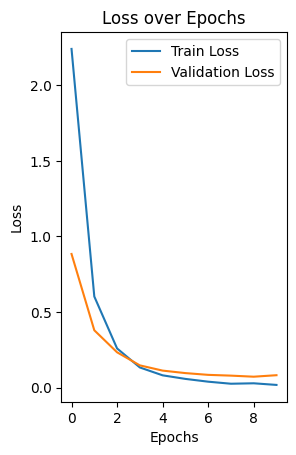

In [71]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

## Conclusion

In this project, we successfully built and trained a Convolutional Neural Network (CNN) to classify German traffic signs using the GTSRB dataset.  
Key takeaways:  
- Data augmentation and normalization helped improve model generalization.  
- The CNN architecture with multiple convolutional blocks achieved strong performance on both training and test sets.  
- EarlyStopping, ModelCheckpoint, and learning rate scheduling ensured efficient training and prevented overfitting.  

This model demonstrates the potential of deep learning in traffic sign recognition, an essential component for autonomous driving and intelligent transportation systems. Future improvements may include hyperparameter tuning, transfer learning with pretrained models, or deployment for real-time detection.
